In [22]:
from diffusers import DDIMScheduler, StableDiffusionPipeline
import numpy as np
import torch
from torch import nn
import os

import inspect
from typing import List, Optional, Tuple, Union

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

4


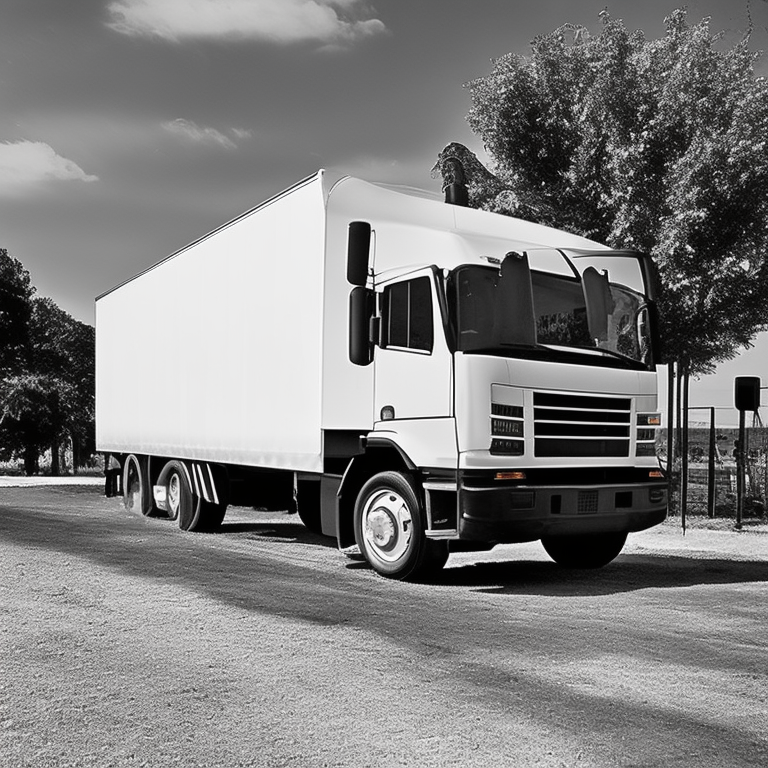

In [11]:
model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe.scheduler = DDIMScheduler.from_config(
    pipe.scheduler.config, rescale_betas_zero_snr=True, timestep_spacing="trailing"
)
pipe = pipe.to("cuda")

prompt = ["truck", "cat"]
images = pipe(prompt, num_inference_steps=20, guidance_scale=9, num_images_per_prompt=2).images
image = images[1]
print(len(images))
image

In [37]:
batch_size = 1
prompt = "a photo of a pizza"
text_emb = pipe._encode_prompt(
    prompt, "cuda", batch_size, True, negative_prompt=None
)
print(f"Shape of text embedding: {text_emb.shape}")

Shape of text embedding: torch.Size([8, 77, 1024])


/home/haselab/anaconda3/envs/distillclip/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:303: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


In [38]:
prompt_with_class = "a photo of a cat"
prompt_without_class = "a photo of a"

untruncated_ids = pipe.tokenizer(prompt_without_class, padding="longest", return_tensors="pt").input_ids
untruncated_ids_class = pipe.tokenizer(prompt_with_class, padding="longest", return_tensors="pt").input_ids

print(f"Untruncated ids: {untruncated_ids}")
print(f"Untruncated ids class: {untruncated_ids_class}")

Untruncated ids: tensor([[49406,   320,  1125,   539,   320, 49407]])
Untruncated ids class: tensor([[49406,   320,  1125,   539,   320,  2368, 49407]])


In [39]:
### First, we have to initialize the class weights

num_classes = 10
num_dims = 1024
class_weights = nn.Parameter(torch.zeros(1, num_classes, num_dims))  # (1, K, D)
class_weights = class_weights.to("cuda")

In [90]:
from transformers.models.clip.modeling_clip import _create_4d_causal_attention_mask

model = pipe.text_encoder.text_model
hidden_states = torch.randn(1, 77, 1024).to("cuda")
input_shape = (1, 77)
causal_attention_mask = _create_4d_causal_attention_mask(
    input_shape, hidden_states.dtype, device=hidden_states.device
)

encoder_outputs = model.encoder(
    inputs_embeds=hidden_states,
    attention_mask=causal_attention_mask,
    causal_attention_mask=causal_attention_mask,
    return_dict=True,
)
last_hidden_state = encoder_outputs[0]
last_hidden_state = model.final_layer_norm(last_hidden_state)
print(f"Last hidden state shape: {last_hidden_state.shape}")


Last hidden state shape: torch.Size([1, 77, 1024])


In [93]:
base_ids = pipe.tokenizer(base_prompt, padding="longest", return_tensors="pt").input_ids.to(device)
base_ids.shape

torch.Size([1, 6])

In [94]:
prompt = "a photo of a "
input_ids = pipe.tokenizer(prompt, padding="max_length", return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

print(f"Input ids: {input_ids.shape}")
model = pipe.text_encoder.text_model
base_embeds = model.embeddings(input_ids)
start_token = base_embeds[:, 0]
start_token.shape

Input ids: torch.Size([1, 77])


torch.Size([1, 1024])

: 

In [73]:
 model.embeddings(torch.tensor([[0]]).to("cuda")).squeeze(0).shape

torch.Size([1, 1024])

In [78]:
pipe.tokenizer.pad_token_id

0

In [82]:
pipe.tokenizer(base_prompt, padding="max_length", return_tensors="pt").input_ids[0]

tensor([49406,   320,  1125,   539,   320, 49407,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])

In [61]:
all_class_text = " ".join(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
input_ids = pipe.tokenizer(all_class_text, padding="longest", return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

embeds = model.embeddings(input_ids)
embeds.shape

torch.Size([1, 12, 1024])

In [40]:
### Then, we replace given class with the class weights

CLASSES_STL10 = [
    "airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"
]
base_prompt = "a photo of a "
prompt = "a photo of a cat"

# get the class index and class embeddings
class_index = CLASSES_STL10.index(prompt.split(base_prompt)[1])
class_embed = class_weights[:, class_index, :]  # (1, D)

# Compute prompt embeddings
prompt_embed = pipe.encode_prompt(
    prompt, "cuda", batch_size, True, negative_prompt=None
)
prompt_embed = torch.cat([prompt_embed[1], prompt_embed[0]]) # (2, M, D)
cond_prompt_embed = prompt_embed[0, ...]  # (M, D)
uncond_prompt_embed = prompt_embed[1, ...]  # (M, D)

max_length = cond_prompt_embed.shape[0]
base_prompt_length = len(pipe.tokenizer(base_prompt, padding="longest", return_tensors="pt").input_ids[0])
prompt_length = len(pipe.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids[0])

print(f"Max length: {max_length}")
print(f"Base prompt length: {base_prompt_length}")
print(f"Prompt length: {prompt_length}")

# base prompt embeddings form: [STRT] word1 word2 ... wordN [END]
# So, we have to remove the first and last token from the prompt embeddings
pad_token = cond_prompt_embed[-1, :].clone().unsqueeze(0)  # (1, D)
end_token = cond_prompt_embed[prompt_length - 1, :].clone().unsqueeze(0)  # (1, D)  
base_prompt_embeds = cond_prompt_embed[:base_prompt_length-1, :].clone()  # [STRT] word1 word2 ... wordN
replaced_prompt_embeds = torch.cat([base_prompt_embeds, class_embed, end_token], dim=0)  # (N+3, D), {STRT} word1 word2 ... wordN class [END]
print(replaced_prompt_embeds.shape)

# We have to pad the prompt embeddings to the maximum length
pad_length = max_length - replaced_prompt_embeds.shape[0]

print(f"Pad length: {pad_length}")
pad_token = pad_token.repeat(pad_length, 1)  # (M - N, D)
replaced_prompt_embeds = torch.cat([replaced_prompt_embeds, pad_token], dim=0)  # (M, D)

# Concat the unconditional prompt embeddings
replaced_prompt_embeds = torch.cat([replaced_prompt_embeds.unsqueeze(0), uncond_prompt_embed.unsqueeze(0)], dim=0)  # (2, M, D)

print(f"replaced_prompt_embeds shape: {replaced_prompt_embeds.shape}")

Max length: 77
Base prompt length: 6
Prompt length: 7
torch.Size([7, 1024])
Pad length: 70
replaced_prompt_embeds shape: torch.Size([2, 77, 1024])


In [24]:
### Now, we have conditional information for the class. 
### Next, we will denoise the image with the conditional information

def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    r"""
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps

# Prepare timesteps
num_inference_steps = 1000
timesteps, num_inference_steps = retrieve_timesteps(
    pipe.scheduler, num_inference_steps, device, timesteps=None, sigmas=None
)
print(f"Timesteps: {timesteps}")

Timesteps: tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 

In [25]:
# Create a dummy image
x = torch.randn(1, 3, 224, 224).to("cuda")

# We feed the image to the encoder of VAE. 
with torch.no_grad():
    z_dist = pipe.vae.encode(x)
z = z_dist.latent_dist.sample()  # (1, d, h, w)
print(f"Lantent z shape: {z.shape}")

# Scheduler class provides the function to add noise to the image. 
# i.e., x_t = \sqrt{alpha_t_bar} * x + sqrt{1 - alpha_t_bar} * N(0, I)
t = torch.randint(0, num_inference_steps, (1,)).item()
eps = torch.randn(*z.shape).to("cuda")
noised_x = pipe.scheduler.add_noise(z, eps, timesteps[t])
noised_x = noised_x.to("cuda")
print(f"Noised x shape: {noised_x.shape}")

# Then, we can denoise the noised image with the conditional information
latent_model_input = torch.cat([noised_x] * 2)  # (2, d, h, w)
noise_pred = pipe.unet(
    latent_model_input, t, encoder_hidden_states=replaced_prompt_embeds, timestep_cond=None, return_dict=False,
)[0]
print(f"Noise pred shape: {noise_pred.shape}")

Lantent z shape: torch.Size([1, 4, 28, 28])
Noised x shape: torch.Size([1, 4, 28, 28])
Noise pred shape: torch.Size([2, 4, 28, 28])


In [26]:
## Compute loss 
# We comptue loss for conditional prediction
cond_noise_pred = noise_pred[:1]
cond_noise_target = noised_x

assert cond_noise_pred.shape == cond_noise_target.shape 
loss = torch.nn.functional.mse_loss(cond_noise_pred, cond_noise_target)
print(f"MSE b/w noised_x and noise_pred: {loss}")

MSE b/w noised_x and noise_pred: 4.913288116455078


In [27]:
# Backpropagation
replaced_prompt_embeds.retain_grad()

loss.backward()

grad_prompt = replaced_prompt_embeds.grad
print(f"Gradient of prompt: {grad_prompt.shape}")

Gradient of prompt: torch.Size([2, 77, 1024])
